### Viualizing Moods

# Step 0. Prereqesites

## 0.1 Load necessary libraries

In [1]:
%%capture

# standard libraries
import pandas as pd
import numpy as np
from numpy import *
import sys

# for visuals
import matplotlib.pyplot as plt 
import matplotlib

# handling files
import zipfile
import os
import fnmatch

# dealing with images
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import skimage
import cv2
from skimage import img_as_ubyte
from PIL import Image
from sklearn import *
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean

#for cleaning up memory
import gc

#for deleting files
import shutil

#for shuffeling the data
import random
from sklearn.utils import shuffle

#for model visuals
!pip install visualkeras
import visualkeras

#for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.layers.serialization import populate_deserializable_objects

# sentinment analyis
!pip install nrclex
from nrclex import NRCLex
import nltk
nltk.download('punkt')


#Importing Libraries
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})


In [2]:
# training was done on google drive to 
from google.colab import drive

#connect to google drive
drive.mount("/content/gdrive", force_remount=True)
%cd gdrive/My\ Drive/Colab_Notebooks/MoodVisualizer/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab_Notebooks/MoodVisualizer


## 0.2 Defining functions

### 0.2.1. Data Loading function

In [62]:

def load_image(path, imagesize):
    """ simple function
    to open an image from path as color image"""
    # open file
    image = cv2.imread(path)
    # change color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #increasing brightness and contrast
    brightness_change = 2
    contrast_change = 1.1
    image = cv2.convertScaleAbs(image, alpha=contrast_change, beta=brightness_change)

    #detect the edges
    #image = cv2.Canny(image,120,120)

    # change size
    image = cv2.resize(image, imagesize)
    return image
      
def load_data(imagesize, data_split_dict, path = './data/'):
    """
    The main functionality to load images as numpy array given a datapath
    Paramater imagesize is a 1x2 array indicating how big the
    loaded image should be, bw meaning if black and white pictures should be loaded.
    """

    # define the dataset
    trainX = []

    for key in data_split_dict.keys():
      for path, subdir, files in os.walk('./filtered_data/' + key + '/'):
        added_samples = 0
        for name in files:
              # keep adding samples until we have collected all the smaples
              # as specified in the dict
              if added_samples < data_split_dict[key]:
                added_samples += 1
                loaded_image = load_image(os.path.join(path, name), imagesize)
                trainX.append(loaded_image)
              else:
                break
    
    # convert to numpy arrays
    trainX = np.array(trainX, dtype = 'float32')  

    # returning scaled image
    return trainX/255

def extract_data_split_from_emotions(sentiments, number_of_samples_needed):

  """ turns the detected sentiments by NRCLex
  into an quantification of how many pictures fitting 
  to each emotions should be loaded"""

  data_split_dict = {}
  sentiment_dict = dict(sentiments)
  sum_of_sentiments = pd.Series(sentiment_dict).sum()

  if len(sentiments) > 6 or sum_of_sentiments == 0:
    data_split_dict["neutral"] = number_of_samples_needed

  else:
    sentiment_dict = dict(sentiments)
    for key in sentiment_dict.keys():

      if key == "anger":
        data_split_dict["anger"] = int(sentiment_dict[key] * number_of_samples_needed)

      if key == "surprise" or key == "anticipation":
        if "curiosity" in data_split_dict:
          data_split_dict["curiosity"] += int(sentiment_dict[key] * number_of_samples_needed)
        else:
          data_split_dict["curiosity"] = int(sentiment_dict[key] * number_of_samples_needed)

      if key == "joy" or key == "trust":
        if "happy" in data_split_dict:
          data_split_dict["happy"] += int(sentiment_dict[key] * number_of_samples_needed)
        else:
          data_split_dict["happy"] = int(sentiment_dict[key] * number_of_samples_needed)

      if key == "disgust":
        data_split_dict["disgust"] = int(sentiment_dict[key] * number_of_samples_needed)

      if key == "fear":
        data_split_dict["fear"] = int(sentiment_dict[key] * number_of_samples_needed)

      if key == "sadness":
        data_split_dict["sad"] = int(sentiment_dict[key] * number_of_samples_needed)

    sum_of_samples = pd.Series(data_split_dict).sum()
    if sum_of_samples < number_of_samples_needed:
      add_to_each_sentiment = (number_of_samples_needed -sum_of_samples ) / len(data_split_dict)
      for key in data_split_dict.keys():
        data_split_dict[key] += int(add_to_each_sentiment)
    else:
      pass

  return data_split_dict

### 0.2.2. Function for Data Analytics

In [63]:
def plot_examples(num_examples, dataset):
  """ method to plot n example of an
  image dataset """

  #filter data
  images = dataset[0:num_examples]

  # create figure
  fig = plt.figure(figsize=(num_examples*2, 5))
    
  # setting values to rows and column variables
  rows = 1
  columns = num_examples

  position = 1
  for i in images: 
    fig.add_subplot(rows, columns, position)
    plt.imshow(i)
    plt.title("Orignal Img #"+ str(position))
    plt.axis('off')
    position = position +1


### 0.2.3. Functions for Visualization & Evaluation of Results

In [131]:
def plot_training(training_data,):

    """ Method to visualize the training history
    of a GAN """

    plt.style.use('seaborn')
    plt.figure(figsize=(8,3), dpi=80)
    plt.plot(training_data.history["Discriminator Loss"], color='#6461c2')
    plt.plot(training_data.history["Generator Loss"], color='#ee0000')
    plt.title('Learning Progress')
    plt.ylabel("Loss Function Value")
    plt.yticks(size=13)
    plt.xlabel('Epoch', size = 13)
    plt.legend(['Discriminator Loss', 'Generator Loss'], loc='upper left')
    plt.show()

# Step 1: Sentiment Analysis & Data Loading

In [65]:
for i in os.listdir("./filtered_data/"):
  print(i)

fear
neutral
anger
curiosity
happy
disgust
sad


In [89]:


input_sentance = "Feeling good today. Wonder what this weekend will look like"

input_sentance = "Today I am feeling quite bad. I have not slept much and \
              I am worried that I will miss my deadlines."

input_sentance = "I am angry about myself, that I missed yesterday, because I \
                  I messed up my timeplan"

input_sentance = "I am angry about myself, that I missed yesterday, because I \
                  I messed up my timeplan"

input_sentance = "I am well. Nothing much going on right now." 

input_sentance = "I am stressed, because of my final exams, so that I don't run out of time." 

input_sentance = "I am feeling alright. There is not much going on in my life right now \
              Just the usual stuff, you know?" 

input_sentance = "I am happy, the weekend is finnally there :)"


text_object = NRCLex(input_sentance)

data_samples_to_load = extract_data_split_from_emotions(dict(text_object.top_emotions), 100)
print(dict(text_object.top_emotions))
print(data_samples_to_load)

{'trust': 0.25, 'positive': 0.25, 'joy': 0.25, 'anticipation': 0.25}
{'happy': 62, 'curiosity': 37}


extracting the zip file

In [90]:
#with zipfile.ZipFile('./FER-2013.zip', 'r') as zip_ref:
 # zip_ref.extractall('./data/')

In [91]:
#loading the dataset
imagesize = (48,48)

trainX = load_data(imagesize, data_samples_to_load)
print(len(trainX))

99


In [92]:
# shuffle data
np.random.shuffle(trainX)
len(trainX)

99

# Step 2: Data Analytics

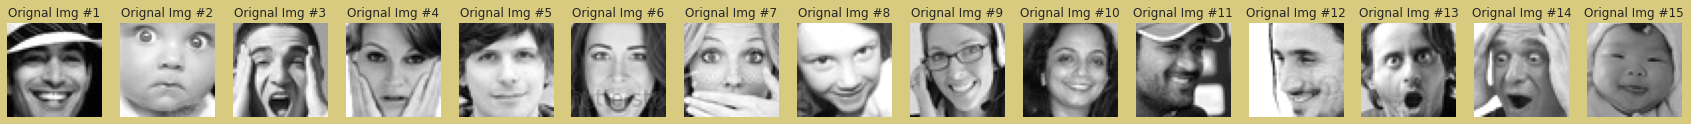

In [93]:
plot_examples(15, trainX)

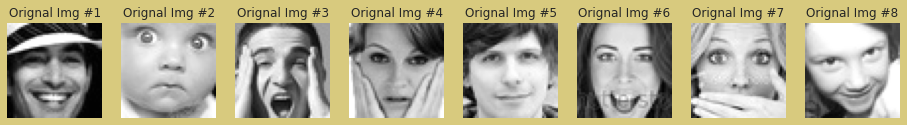

In [94]:
plot_examples(8, trainX)

# Step 3. Building Models

## Step 3.1. Generator

This model will be used to create new images. It takes as input random noise and tries to learn to modify/change this random noise with several layers so we get a realistc image.

The results from the generator GAN will later on compared with the actual images images and the discriminator will tell us weather it thinks they are fake or not. If the discriminator fail to identify them as fakes we know that we have done something right when generating the images.

In order to use this learning we will update the weights in this model so that
the generator can produce more realistic/meaningful images.

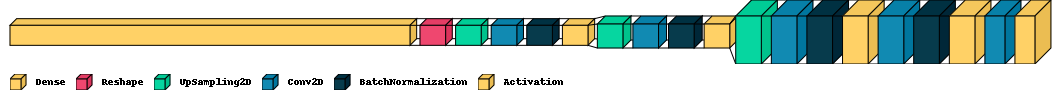

In [95]:
# often also called latent_dim and stands for the number of nodes 
# we use as input for the generator
generator_input_dimension = 150

generator = tf.keras.Sequential([
    
    # Model to generate new images. 
    # Combines several standard building blocks from Keras.

    tf.keras.layers.Input(shape=generator_input_dimension),
    tf.keras.layers.Dense(6*6*256,activation="relu"), 
    tf.keras.layers.Reshape((6,6,256)),

    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(256, kernel_size=3,padding="same"),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(256, kernel_size=3,padding="same"),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(256, kernel_size=3,padding="same"),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(256, kernel_size=3,padding="same"),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(3, kernel_size=3,padding="same"),
    tf.keras.layers.Activation("tanh"),
])

# compile the model
generator.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(generator, scale_xy =1, legend=True)



**Test run before training**


Creating an output from our generator before training to visualize how random noise would look like as picture

6912

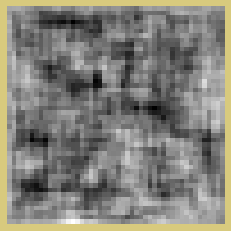

In [96]:
# create random noise
noise = tf.random.normal([1, generator_input_dimension])
# put it into the generator function to create image
created_image = generator(noise, training=False)
# show the results
plt.imshow(created_image[0, :, :, 0], cmap ="gray", interpolation="nearest")
plt.axis("off")
size(created_image)

## Step 3.2. Discriminator

this model that will be used to decide if images are real or not - based on the decision of this model we can improve our image generation.

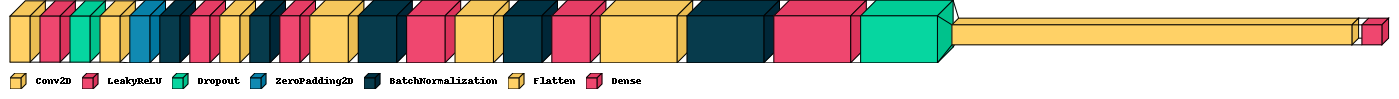

In [97]:
conv_size = 48

discriminator = tf.keras.Sequential([
    
    # Model used to decide if an image is real or not.
    # Again we use keras layers as building blocks.

    tf.keras.layers.Conv2D(conv_size, (3, 3), activation = 'relu', input_shape = (imagesize[0], imagesize[1], 3)), 

    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(conv_size*2, (3, 2), padding="same"),
    tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),

    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(conv_size*2*2, (3, 2), padding="same"),
    tf.keras.layers.BatchNormalization(momentum=0.8),

    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(conv_size*2*2*2, (3, 2), padding="same"),
    tf.keras.layers.BatchNormalization(momentum=0.8),

    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(conv_size*2*2*2, (3, 2), padding="same"),
    tf.keras.layers.BatchNormalization(momentum=0.8),

    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(conv_size*2*2*2*2, (3, 2), padding="same"),
    tf.keras.layers.BatchNormalization(momentum=0.8),


    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile the model
discriminator.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(discriminator, scale_xy =1, legend=True)

## Step 3.3. GAN

In [98]:
class GAN(tf.keras.Model):

    """ The class model for our GAN model
    which combines generator and disriminator
    and defines how the can interact with each other"""

    def __init__(self, discriminator, generator, generator_input_dimension):
        """ method to build a new instance of a GAN """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.generator_input_dimension = generator_input_dimension

    def compile(self, discriminator_optm, generator_optm, loss_fn):
        """ first method which is necessary so we can learn and
        improve the generated images """
        super(GAN, self).compile()
        self.discriminator_optm = discriminator_optm
        self.generator_optm = generator_optm
        self.loss_fn = loss_fn
        self.discriminator_loss_metric = tf.keras.metrics.Mean(name="discriminator_loss")
        self.generator_loss_metric = tf.keras.metrics.Mean(name="generator_loss")

    @property
    def metrics(self):
        return [self.discriminator_loss_metric, self.generator_loss_metric]

    def train_step(self, real_images):
        """ second method which is necessary so we can learn and
        improve the generated images 
        The core of the GAN model"""

        # Generate random noise
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.generator_input_dimension))
        # use it to generate images
        generated_images = self.generator(noise)
        # combine with them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # add noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        # Get the Gradient to update the weight of the model, so the model can learn
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            discriminator_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.discriminator_optm.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate random noise in the latent space
        noise = tf.random.normal(shape=(batch_size, self.generator_input_dimension))
        misleading_labels = tf.zeros((batch_size, 1))

        # Get the Gradient to update the weight of the model, so the model can learn
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise))
            generator_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(generator_loss, self.generator.trainable_weights)
        self.generator_optm.apply_gradients(zip(grads, self.generator.trainable_weights))
        #store the results
        self.discriminator_loss_metric.update_state(discriminator_loss)
        self.generator_loss_metric.update_state(generator_loss)
        return {"Discriminator Loss": self.discriminator_loss_metric.result(), "Generator Loss": self.generator_loss_metric.result()}

# create a new instance of type GAN model
model = GAN(discriminator=discriminator, generator=generator, generator_input_dimension=generator_input_dimension)
# and compile the the model
model.compile(discriminator_optm=tf.keras.optimizers.Adamax(1.5e-4,0.5), 
              generator_optm=tf.keras.optimizers.Adamax(1.5e-4,0.5), 
              loss_fn= tf.keras.losses.BinaryCrossentropy())

**Training the Model**

In [99]:
%%capture
#Fitting the GAN
history = model.fit(trainX, epochs=250, batch_size=6)

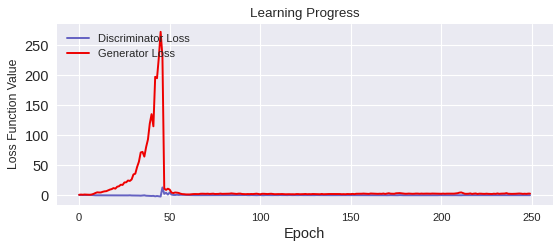

In [132]:
plot_training(history)

In [100]:

def generate_pictures(n_of_pics_to_generate, generator):
    """ A simple function to 
    generate a number of pictures as specified 
    via a trained generator """

    #list to store the results
    new_images = []

    #generate random noise
    noise = tf.random.normal([n_of_pics_to_generate, generator_input_dimension])
    #create new images
    created_images = generator(noise)
    #put in right format and store
    created_images *= 255 
    created_images = created_images.numpy()
    for i in range(n_of_pics_to_generate):
            image = tf.keras.preprocessing.image.array_to_img(created_images[i])
            new_images.append(image)
    return new_images

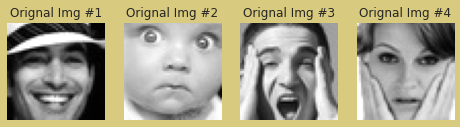

In [101]:
plot_examples(4, trainX)

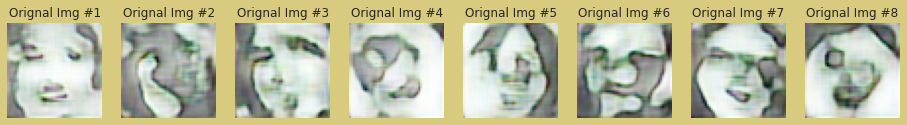

In [105]:
# generate new images
Images = generate_pictures(8, generator)

plot_examples(8, Images)

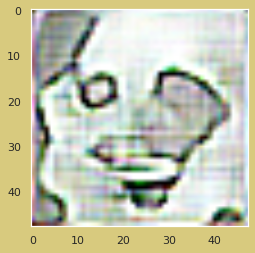

In [103]:
image = np.array(Images[3])
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

plt.imshow(image_sharp,cmap="hot", interpolation="bilinear")
plt.grid(False)